# Analysis Notebook for Log Data

In [37]:
%matplotlib notebook

## Load Data from Archive

In [38]:
import os
import pickle

log_path = "./log_prelim"

groups = {}   # header_without_seed -> list of values dicts

for run_dir in os.listdir(log_path):
    run_path = os.path.join(log_path, run_dir)

    if not os.path.isdir(run_path):
        continue

    header_path = os.path.join(run_path, "header.pickle")
    values_path = os.path.join(run_path, "0-values.pickle")

    if not (os.path.exists(header_path) and os.path.exists(values_path)):
        continue

    # Load header
    with open(header_path, "rb") as f:
        header = pickle.load(f)

    # Remove seed
    header_no_seed = {k: v for k, v in header.items() if k != "seed"}

    # Convert dict to immutable & sortable key
    key = tuple(sorted(header_no_seed.items()))

    # Load values
    with open(values_path, "rb") as f:
        values = pickle.load(f)

    # Insert into groups
    groups.setdefault(key, []).append(values)


## Visualize the Data
- This was only used to see the data once

In [39]:
# import matplotlib.pyplot as plt

# os.mkdir("tmp/")

# for idx, (group_key, run_values) in enumerate(groups.items()):
#     # Extract the metrics
#     steps = [v["step_count"] for v in run_values]
#     weights = [v["weight_shifted"] for v in run_values]

#     # --- Plot ---
#     plt.figure(figsize=(7, 5))
#     plt.scatter(steps, weights)

#     plt.xlabel("Steps")
#     plt.ylabel("Weight Shifted")
#     plt.grid(True, alpha=0.3)

#     # Create a readable title (shortened)
#     title_params = {k: v for k, v in group_key}
#     short_title = (
#         f"{title_params['map_name']}, "
#         f"dim={title_params['env_dim']}, "
#         f"T={title_params['total_budget']}, "
#         f"sim={title_params['simulation_method']}"
#     )

#     plt.title(f"Group {idx+1}: {len(run_values)} runs\n{short_title}")

#     plt.tight_layout()
#     plt.savefig(f"./tmp/fig-{idx}.png")
#     plt.close()

#     # Also print full parameters to console for reference
#     print(f"\nGroup {idx+1} parameters:")
#     for k, v in group_key:
#         print(f"  {k}: {v}")


# Analysis for Best Parameters

<IPython.core.display.Javascript object>

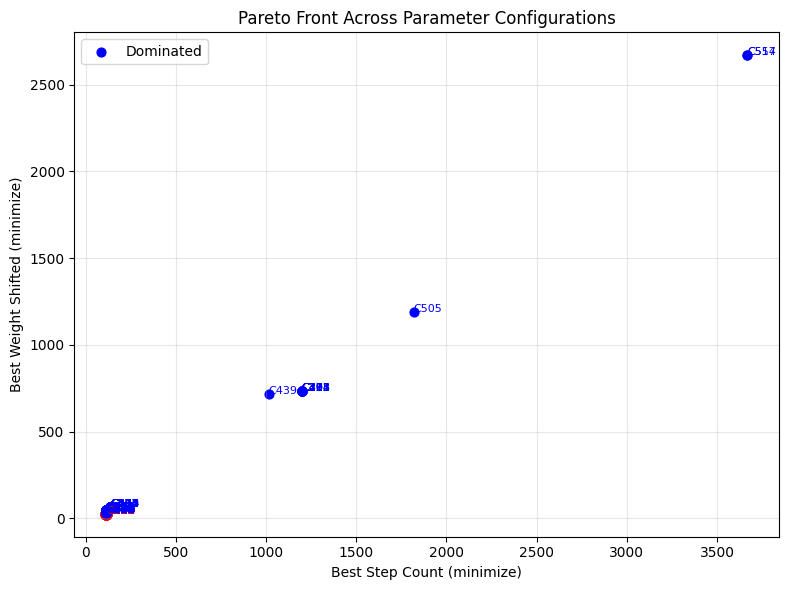


Pareto-optimal configurations:

Config (best steps=116, weight=26.42297890149554):
  env_dim: 30
  goal: (29, 29)
  map_name: random_map
  max_pareto_paths: 20
  number_of_simulations: 250
  per_sim_budget: 50
  root_selection_method: epsilon_clustering_for_nodes
  simulation_method: 1
  start: (0, 0)
  total_budget: 5000000
  tree_selection_method: pareto_path_child_selection_cd

Config (best steps=116, weight=26.42297890149554):
  env_dim: 30
  goal: (29, 29)
  map_name: random_map
  max_pareto_paths: 20
  number_of_simulations: 250
  per_sim_budget: 50
  root_selection_method: pareto_path_child_selection_cd
  simulation_method: 0
  start: (0, 0)
  total_budget: 5000000
  tree_selection_method: pareto_path_child_selection_hv

Config (best steps=116, weight=26.42297890149554):
  env_dim: 30
  goal: (29, 29)
  map_name: random_map
  max_pareto_paths: 20
  number_of_simulations: 250
  per_sim_budget: 50
  root_selection_method: pareto_path_child_selection_hv
  simulation_method: 0
  st

In [40]:
import matplotlib.pyplot as plt
from IPython.display import display

def best_run_for_group(run_values):
    """Return the best (steps, weight_shifted) for a group (minimizing both)."""
    best = min(
        run_values,
        key=lambda v: (v["step_count"], v["weight_shifted"])
    )
    return best["step_count"], best["weight_shifted"]


def pareto_best_groups(groups):
    """
    Returns a list of (group_key, steps, weight_shifted)
    that lie on the Pareto front.
    """
    # Step 1: compute representative best points
    reps = []
    for key, values in groups.items():
        s, w = best_run_for_group(values)
        reps.append((key, s, w))

    # Step 2: compute non-dominated points
    pareto_front = []

    for i, (key_i, s_i, w_i) in enumerate(reps):
        dominated = False
        for j, (key_j, s_j, w_j) in enumerate(reps):
            if i == j:
                continue

            # j dominates i
            if (s_j <= s_i and w_j <= w_i) and (s_j < s_i or w_j < w_i):
                dominated = True
                break

        if not dominated:
            pareto_front.append((key_i, s_i, w_i))

    return pareto_front


def visualize_pareto_front(groups):
    # Compute representative best points
    reps = []
    for key, values in groups.items():
        steps, weight = best_run_for_group(values)
        reps.append((key, steps, weight))

    # Compute Pareto front
    pareto_front = pareto_best_groups(groups)
    pareto_keys = {id(k): (s, w) for k, s, w in pareto_front}

    # Build figure
    plt.figure(figsize=(8, 6))

    # Plot all configurations
    for i, (key, s, w) in enumerate(reps):
        label = f"C{i}"

        if id(key) in pareto_keys:
            plt.scatter(s, w, color="red", s=60, label="Pareto-optimal" if i == 0 else "")
            plt.annotate(label, (s, w), color="red", fontsize=8)
        else:
            plt.scatter(s, w, color="blue", s=40, label="Dominated" if i == 0 else "")
            plt.annotate(label, (s, w), color="blue", fontsize=8)

    plt.xlabel("Best Step Count (minimize)")
    plt.ylabel("Best Weight Shifted (minimize)")
    plt.title("Pareto Front Across Parameter Configurations")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    display(plt.gcf())
    plt.close()

    # Print textual summary
    print("\nPareto-optimal configurations:")
    for key, s, w in pareto_front:
        print(f"\nConfig (best steps={s}, weight={w}):")
        for k, v in key:
            print(f"  {k}: {v}")

front = pareto_best_groups(groups)

visualize_pareto_front(groups)